In [17]:
import pandas as pd
import numpy as np
import os
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

train_df = pd.read_csv("Data/train_df.csv")
test_df = pd.read_csv("Data/test_df.csv")

display(train_df.describe())
train_df.info()

,Electric_Consumption,Factor_A,Factor_B,Factor_C,Factor_D,Factor_E,Factor_F
count,13872.000000,13872.000000,13872.000000,13872.000000,13872.000000,13872.000000,13872.000000
mean,5.893120,2.262227,19.977867,40.332796,145.005668,0.209435,42.522214
std,7.355969,1.457234,9.607866,24.324671,94.993992,1.691576,280.466514
min,-0.009717,-74.220598,-5.422289,3.249366,-1380.363752,0.000000,0.000000
25%,0.000000,1.105756,13.088434,20.396742,106.883078,0.000000,0.579665
50%,0.086858,1.995936,20.187978,34.024351,138.044038,0.000000,1.981719
75%,13.512742,3.261530,26.994172,57.191932,209.901463,0.000000,60.123072
max,21.360638,8.392045,44.036205,101.706771,312.895406,31.000006,31839.840610


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13872 entries, 0 to 13871
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  13872 non-null  object 
 1   Electric_Consumption  13872 non-null  float64
 2   Factor_A              13872 non-null  float64
 3   Factor_B              13872 non-null  float64
 4   Factor_C              13872 non-null  float64
 5   Factor_D              13872 non-null  float64
 6   Factor_E              13872 non-null  float64
 7   Factor_F              13872 non-null  float64
dtypes: float64(7), object(1)
memory usage: 867.1+ KB


In [18]:
train_df['Date'] = pd.to_datetime(train_df['Date'])
test_df['Date'] = pd.to_datetime(test_df['Date'])

#Feature extraction
for df in [train_df, test_df]:
    df['Hour'] = df['Date'].dt.hour
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day

display(train_df.head())

,Date,Electric_Consumption,Factor_A,Factor_B,Factor_C,Factor_D,Factor_E,Factor_F,Hour,DayOfWeek,Month,Day
0,2023-01-01 00:00:00,0.000000,1.242130,28.419739,13.720397,79.840600,0.0,2.386157,0,6,1,1
1,2023-01-01 01:00:00,0.000000,1.861285,29.840759,12.537668,86.424903,0.0,1.473256,1,6,1,1
2,2023-01-01 02:00:00,0.000000,4.212674,32.778036,9.408667,72.082793,0.0,1.583711,2,6,1,1
3,2023-01-01 03:00:00,0.000000,4.025251,32.624700,9.035601,73.825705,0.0,1.706656,3,6,1,1
4,2023-01-01 04:00:00,-0.000267,3.122659,31.931245,9.235502,66.823956,0.0,0.987048,4,6,1,1


In [19]:
# Check the number of missing values in each column of the DataFrame
train_df.isnull().sum().sum()

0

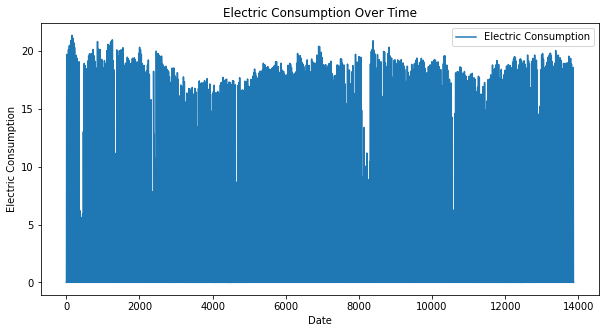

In [20]:
# Plot the electric consumption over time
plt.figure(figsize=(10, 5))
plt.plot(train_df.index, train_df['Electric_Consumption'], label='Electric Consumption')
plt.title('Electric Consumption Over Time')
plt.xlabel('Date')
plt.ylabel('Electric Consumption')
plt.legend()
plt.show()

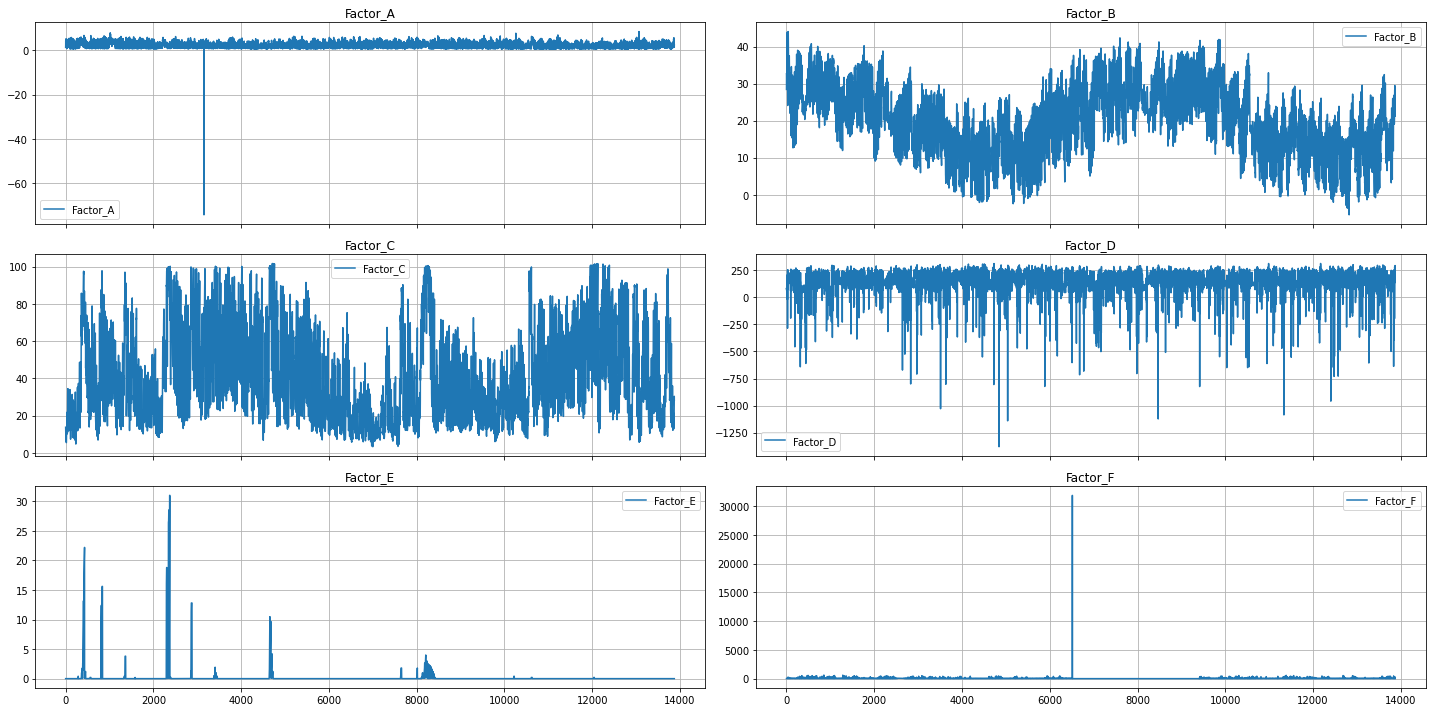

In [21]:
# Create subplots for different factors
fig, axs = plt.subplots(3, 2, figsize=(20, 10), sharex=True)
axs = axs.flatten()

features = ['Factor_A', 'Factor_B', 'Factor_C', 'Factor_D', 'Factor_E', 'Factor_F', 'Hour', 'DayOfWeek', 'Month', 'Day']

# Plot each feature in its respective subplot
for i, factor in enumerate(features[:6]):
    axs[i].plot(train_df.index, train_df[factor], label=factor)
    axs[i].set_title(factor)
    axs[i].legend()
    axs[i].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [ ]:
X = train_df[features]
y = train_df['Electric_Consumption']
X_test = test_df[features]

# Standardization of features
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_test = scaler.transform(X_test)


In [23]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=6, subsample=0.8, colsample_bytree=0.8)
model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

val_predictions = model.predict(X_val)
val_predictions = np.clip(val_predictions, 0, None) #######

RMSE_val = np.sqrt(mean_squared_error(y_val, val_predictions))
print(f"RMSE on Validation Set: {RMSE_val}")

RMSE on Validation Set: 3.0816366354407787


In [24]:
predictions = model.predict(X_test)
predictions = np.clip(predictions, 0, None)

output_file = "Data\\submission.csv"
if os.path.exists(output_file):
    os.remove(output_file)
submission = pd.DataFrame({'Date': test_df['Date'], 'Electric_Consumption': predictions})
submission.to_csv(output_file, index=False)

print("File submission.csv salvato con successo!")

File submission.csv salvato con successo!
